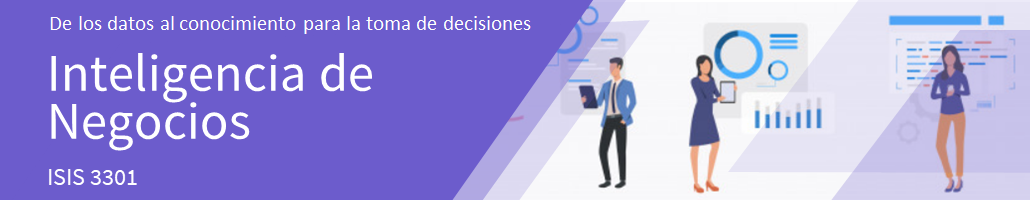

## Parcial 1 Etapa 2.
## Regresión Lineal

En este notebook se planteara el uso de un algoritmo de regresión lineal con el fin de modelar la importancia que tiene cada característica implicada en la gravedad de los accidentes de tráfico.

Para esto, se plantea usar este algoritmo de regresión con el fin de obtener los coeficientes que tiene cada variable y el efecto que tienen estos para predecir la gravedad de los accidentes de tráfico, para esto se deben preparar los datos numéricos, y en caso que se necesite, transformar datos clasificadores a numéricos.

Esta propuesta es apropiada debido a que este algoritmo permite predecir una variable debido a los coeficientes asignados a cada variable, conocer la importancia de cada una de ellas en la predicción de la gravedad de un incidente con el fin de evitar que estos incidentes sean graves o se mantengan en lo menos grave posible.

1. Importación de librerías.
2. Carga de los datos.
3. Limpieza y preparación de los datos.
4. Construcción del modelo.
5. Evaluación del modelo.
6. Interpretación del modelo.

### 1. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [1]:
seed = 161
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Para sacar un reporte estadístico que podemos usar para determinar las importancia de las variables explicativas.
import statsmodels.api as sm 

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
# Para determinar el rendimiento del modelo con las métricas MSE, MAE y R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# q-q plots
import scipy.stats as stats

### 2. Carga de los datos
A través de la librería pandas resalizamos la carga de datos del archivo "Accidentes.csv". el separador que se usará para la carga es ";".

In [2]:
# Se cargan los datos. 
df=pd.read_csv('Accidentes.csv', sep=';')

In [3]:
# Cantidad de datos y número de variables
df.shape

(2809, 12)

In [4]:
df.dtypes

ID                        object
Severidad_accidente       object
Numero_vehiculos           int64
Numero_victimas           object
Dia_semana                 int64
Tipo_via                  object
Limite_velocidad           int64
Iluminacion               object
Clima                     object
Condicion_via             object
Condiciones especiales    object
Tipo_area                 object
dtype: object

Como podemos ver hay datos que deberían ser numéricos, pero por alguna razón estos son tipo "object".

In [5]:
# Mostrar los datos
df.head()

,ID,Severidad_accidente,Numero_vehiculos,Numero_victimas,Dia_semana,Tipo_via,Limite_velocidad,Iluminacion,Clima,Condicion_via,Condiciones especiales,Tipo_area
0,201143N077061,Fatal,5,1,7,Autovia,70,Luz_dia,Bueno,Seca,No,Rural
1,200697LB70507,Fatal,1,1,2,Calzada,60,Luz_dia,Bueno,Seca,No,Rural
2,200897UA70101,Fatal,1,1,4,Calzada,30,Oscuridad con luces encendidas,Bueno,Humeda,No,Urbano
3,20114100D0277,Fatal,1,1,4,Calzada,40,Oscuridad sin iluminacion,Bueno,Seca,No,Rural
4,20141316C1381,Fatal,1,1,5,Calzada,40,Luz_dia,Bueno,Seca,No,Rural


Se corrige la columna de número victimas que no tiene tipo de dato correcto. Para esto se eliminan los outlier y se toman todos los datos como integer, es decir, cualquier dato float es transformado al entero más proximo.

In [6]:
df.loc[df['Numero_victimas'] == '70.000.000']
df.loc[df['Numero_victimas'] == '44444444']
df = df.drop(df.index[1565])
df = df.drop(df.index[107])
df['Numero_victimas'] = pd.to_numeric(df['Numero_victimas'], downcast="integer")
df['Numero_victimas']=df['Numero_victimas'].astype(int)
df.dtypes

ID                        object
Severidad_accidente       object
Numero_vehiculos           int64
Numero_victimas            int32
Dia_semana                 int64
Tipo_via                  object
Limite_velocidad           int64
Iluminacion               object
Clima                     object
Condicion_via             object
Condiciones especiales    object
Tipo_area                 object
dtype: object

### 3. Limpieza y preparación de los datos

Para la limpieza de datos, se revisa que no registros vacios o hayan duplicados. Luego para la preparación de datos, se decide transformar variables categóricas a numéricas para el modelo

In [7]:
# Se observa si hay ausencias
# También decidimos eliminar la columna ID ya que no nos sirve para el modelo
df_accidentes = df.copy()
df_accidentes.drop('ID', axis=1, inplace=True)
df_accidentes.isnull().sum()

Severidad_accidente        5
Numero_vehiculos           0
Numero_victimas            0
Dia_semana                 0
Tipo_via                  17
Limite_velocidad           0
Iluminacion                1
Clima                     15
Condicion_via              0
Condiciones especiales     0
Tipo_area                  1
dtype: int64

Como son pocas ausencias, decidimos eliminar todos los registros que las tengan.

In [8]:
df_accidentes = df_accidentes.dropna()
df_accidentes.shape

(2768, 11)

In [9]:
df_accidentes.duplicated(keep=False)

0       False
1        True
2       False
3        True
4       False
        ...  
2804    False
2805     True
2806     True
2807    False
2808    False
Length: 2768, dtype: bool

In [10]:
# Acá podemos ver las columnas con datos numéricos
df_accidentes.describe()

,Numero_vehiculos,Numero_victimas,Dia_semana,Limite_velocidad
count,2768.000000,2768.000000,2768.000000,2768.000000
mean,1.798049,1.379335,4.150650,44.423410
std,0.720426,0.845426,1.972908,208.474485
min,1.000000,1.000000,1.000000,-70.000000
25%,1.000000,1.000000,2.000000,30.000000
50%,2.000000,1.000000,4.000000,30.000000
75%,2.000000,1.250000,6.000000,50.000000
max,8.000000,13.000000,12.000000,7777.000000


Ahora podemos ver los datos que queremos transformar a numéricos, esto se debe a que Scikit-learn requiere que todos los atributos sean numéricos y que la variable objetivo, en una tarea de clasificación, esté codificada con números.

In [11]:
df_accidentes['Tipo_via'].value_counts()

Calzada             2078
Autovia              449
Rotonda              157
Un solo sentido       58
Carretera acceso      26
Name: Tipo_via, dtype: int64

In [12]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_via (row):
    if row['Tipo_via'] == 'Calzada' :
        return 1
    elif row['Tipo_via'] == 'Autovia' :
        return 2
    elif row['Tipo_via'] == 'Rotonda' :
        return 3
    elif row['Tipo_via'] == 'Un solo sentido' :
        return 4
    return 5
df_accidentes['Tipo_Via']=df_accidentes.apply (lambda row: definir_via(row), axis=1)   
df_accidentes['Tipo_Via'].value_counts()

1    2078
2     449
3     157
4      58
5      26
Name: Tipo_Via, dtype: int64

In [13]:
df_accidentes['Iluminacion'].value_counts()

Luz_dia                           1966
Oscuridad con luces encendidas     607
Oscuridad sin iluminacion          162
0                                   20
Oscuridad con luces apagadas        13
Name: Iluminacion, dtype: int64

In [14]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def Iluminacion_via (row):
    if row['Iluminacion'] == 'Luz_dia' :
        return 1
    elif row['Iluminacion'] == 'Oscuridad con luces encendidas' :
        return 2
    elif row['Iluminacion'] == 'Oscuridad sin iluminacion' :
        return 3
    return 4
df_accidentes['Iluminacion_Via']=df_accidentes.apply (lambda row: Iluminacion_via(row), axis=1)   
df_accidentes['Iluminacion_Via'].value_counts()

1    1966
2     607
3     162
4      33
Name: Iluminacion_Via, dtype: int64

In [15]:
df_accidentes['Clima'].value_counts()

Bueno                 2246
Lluvioso               316
Ventoso                 81
Nieve y ventoso         54
Niebla                  45
Nieve                   21
LLuvioso y ventoso       5
Name: Clima, dtype: int64

In [16]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def tipo_clima (row):
    if row['Clima'] == 'Bueno' :
        return 1
    elif row['Clima'] == 'Lluvioso' :
        return 2
    elif row['Clima'] == 'Ventoso' :
        return 3
    elif row['Clima'] == 'Niebla' :
        return 3
    return 5
df_accidentes['tipo_clima']=df_accidentes.apply (lambda row: tipo_clima(row), axis=1)   
df_accidentes['tipo_clima'].value_counts()

1    2246
2     316
3     126
5      80
Name: tipo_clima, dtype: int64

In [17]:
df_accidentes['Condicion_via'].value_counts()

Seca         1884
Humeda        807
Hielo          57
Con nieve      18
Inundada        2
Name: Condicion_via, dtype: int64

In [18]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_condicion (row):
    if row['Condicion_via'] == 'Seca' :
        return 1
    elif row['Condicion_via'] == 'Humeda' :
        return 2
    elif row['Condicion_via'] == 'Hielo' :
        return 3
    elif row['Condicion_via'] == 'Con nieve' :
        return 4
    return 5
df_accidentes['Condicion_Via']=df_accidentes.apply (lambda row: definir_condicion(row), axis=1)   
df_accidentes['Condicion_Via'].value_counts()

1    1884
2     807
3      57
4      18
5       2
Name: Condicion_Via, dtype: int64

In [19]:
df_accidentes['Condiciones especiales'].value_counts()

No    2710
Si      58
Name: Condiciones especiales, dtype: int64

In [20]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_condicion_especial (row):
    if row['Condiciones especiales'] == 'Si' :
        return 1
    return 0
df_accidentes['Condicion_especial_Via']=df_accidentes.apply (lambda row: definir_condicion_especial(row), axis=1)   
df_accidentes['Condicion_especial_Via'].value_counts()

0    2710
1      58
Name: Condicion_especial_Via, dtype: int64

In [21]:
df_accidentes['Tipo_area'].value_counts()

Urbano    1859
Rural      909
Name: Tipo_area, dtype: int64

In [22]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_tipo_area (row):
    if row['Tipo_area'] == 'Urbano' :
        return 1
    return 0
df_accidentes['Tipo_Area']=df_accidentes.apply (lambda row: definir_tipo_area(row), axis=1)   
df_accidentes['Tipo_Area'].value_counts()

1    1859
0     909
Name: Tipo_Area, dtype: int64

In [23]:
df_accidentes.head()

,Severidad_accidente,Numero_vehiculos,Numero_victimas,Dia_semana,Tipo_via,Limite_velocidad,Iluminacion,Clima,Condicion_via,Condiciones especiales,Tipo_area,Tipo_Via,Iluminacion_Via,tipo_clima,Condicion_Via,Condicion_especial_Via,Tipo_Area
0,Fatal,5,1,7,Autovia,70,Luz_dia,Bueno,Seca,No,Rural,2,1,1,1,0,0
1,Fatal,1,1,2,Calzada,60,Luz_dia,Bueno,Seca,No,Rural,1,1,1,1,0,0
2,Fatal,1,1,4,Calzada,30,Oscuridad con luces encendidas,Bueno,Humeda,No,Urbano,1,2,1,2,0,1
3,Fatal,1,1,4,Calzada,40,Oscuridad sin iluminacion,Bueno,Seca,No,Rural,1,3,1,1,0,0
4,Fatal,1,1,5,Calzada,40,Luz_dia,Bueno,Seca,No,Rural,1,1,1,1,0,0


In [24]:
# Eliminaremos las columnas que ya transformamos
df_accidentes_prep = df_accidentes.drop(['Tipo_via', 'Iluminacion', 'Clima', 'Condicion_via', 'Condiciones especiales', 'Tipo_area'], axis=1)
df_accidentes_prep.dtypes

Severidad_accidente       object
Numero_vehiculos           int64
Numero_victimas            int32
Dia_semana                 int64
Limite_velocidad           int64
Tipo_Via                   int64
Iluminacion_Via            int64
tipo_clima                 int64
Condicion_Via              int64
Condicion_especial_Via     int64
Tipo_Area                  int64
dtype: object

Ahora se prepara la variable objetivo

In [25]:
df_accidentes_prep['Severidad_accidente'].value_counts()

Leve     1868
Serio     610
Fatal     290
Name: Severidad_accidente, dtype: int64

In [26]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def definir_condicion (row):
    if row['Severidad_accidente'] == 'Leve' :
        return 1
    elif row['Severidad_accidente'] == 'Serio' :
        return 2
    return 3
df_accidentes_prep['Severidad']=df_accidentes_prep.apply (lambda row: definir_condicion(row), axis=1)
df_accidentes_prep.drop('Severidad_accidente', axis=1, inplace=True)
df_accidentes_prep['Severidad'].value_counts()

1    1868
2     610
3     290
Name: Severidad, dtype: int64

In [27]:
# Podemos ver como quedaron los datos
df_accidentes_prep.head()

,Numero_vehiculos,Numero_victimas,Dia_semana,Limite_velocidad,Tipo_Via,Iluminacion_Via,tipo_clima,Condicion_Via,Condicion_especial_Via,Tipo_Area,Severidad
0,5,1,7,70,2,1,1,1,0,0,3
1,1,1,2,60,1,1,1,1,0,0,3
2,1,1,4,30,1,2,1,2,0,1,3
3,1,1,4,40,1,3,1,1,0,0,3
4,1,1,5,40,1,1,1,1,0,0,3


In [28]:
# Revisión del total de registros
df_model = df_accidentes_prep.copy()
df_model.shape

(2768, 11)

### 3.1 Búsqueda de relaciones entre variables (diagramas de dispersión)

Buscamos cuales de las columnas tienen una *relacion* con Severidad

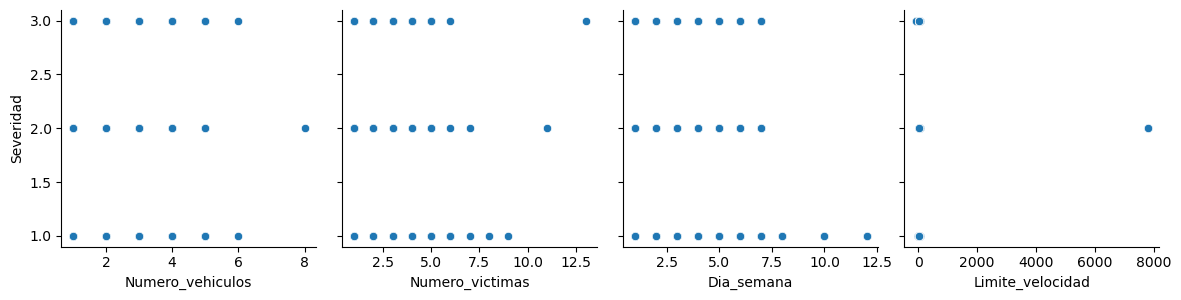

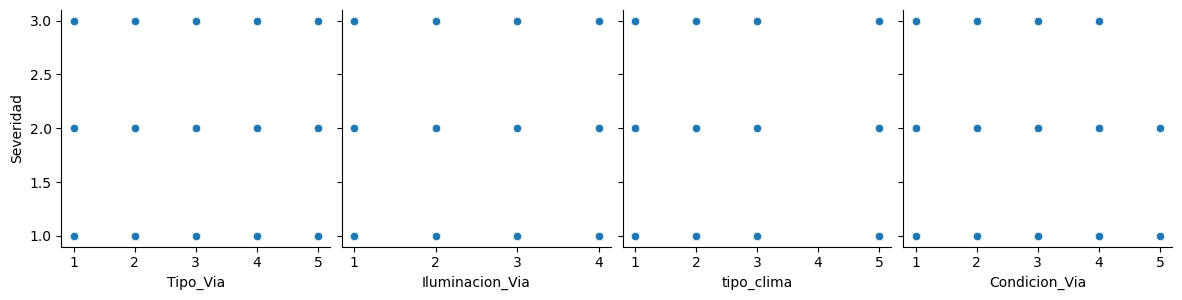

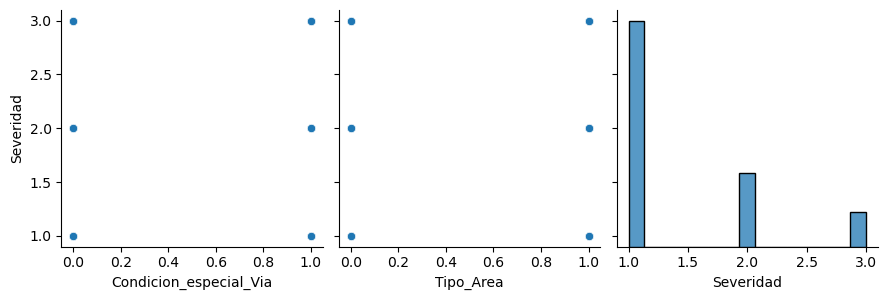

In [29]:
sns.pairplot(df_model, height=3, y_vars = 'Severidad', x_vars = df_model.columns[0:4], kind='scatter')
sns.pairplot(df_model, height=3, y_vars = 'Severidad', x_vars = df_model.columns[4:8], kind='scatter')
sns.pairplot(df_model, height=3, y_vars = 'Severidad', x_vars = df_model.columns[8:11], kind='scatter')
plt.show()

Al mirar las gáficas no nos dan mucha información debido a que gran cantidad de las variables utilizadas eran categóricas, y por tanto se agrupan en grupos bien definidos. 
Igualmente, al ser la variable objetivo también una variable categórica, no aporta a ver gráficamente la relación entre variables.

### 3.2 Búsqueda de relaciones entre variables (Matriz de correlaciones)

Buscamos cuales de las columnas tienen una *relacion* con Severidad pero ahora usando correlaciones

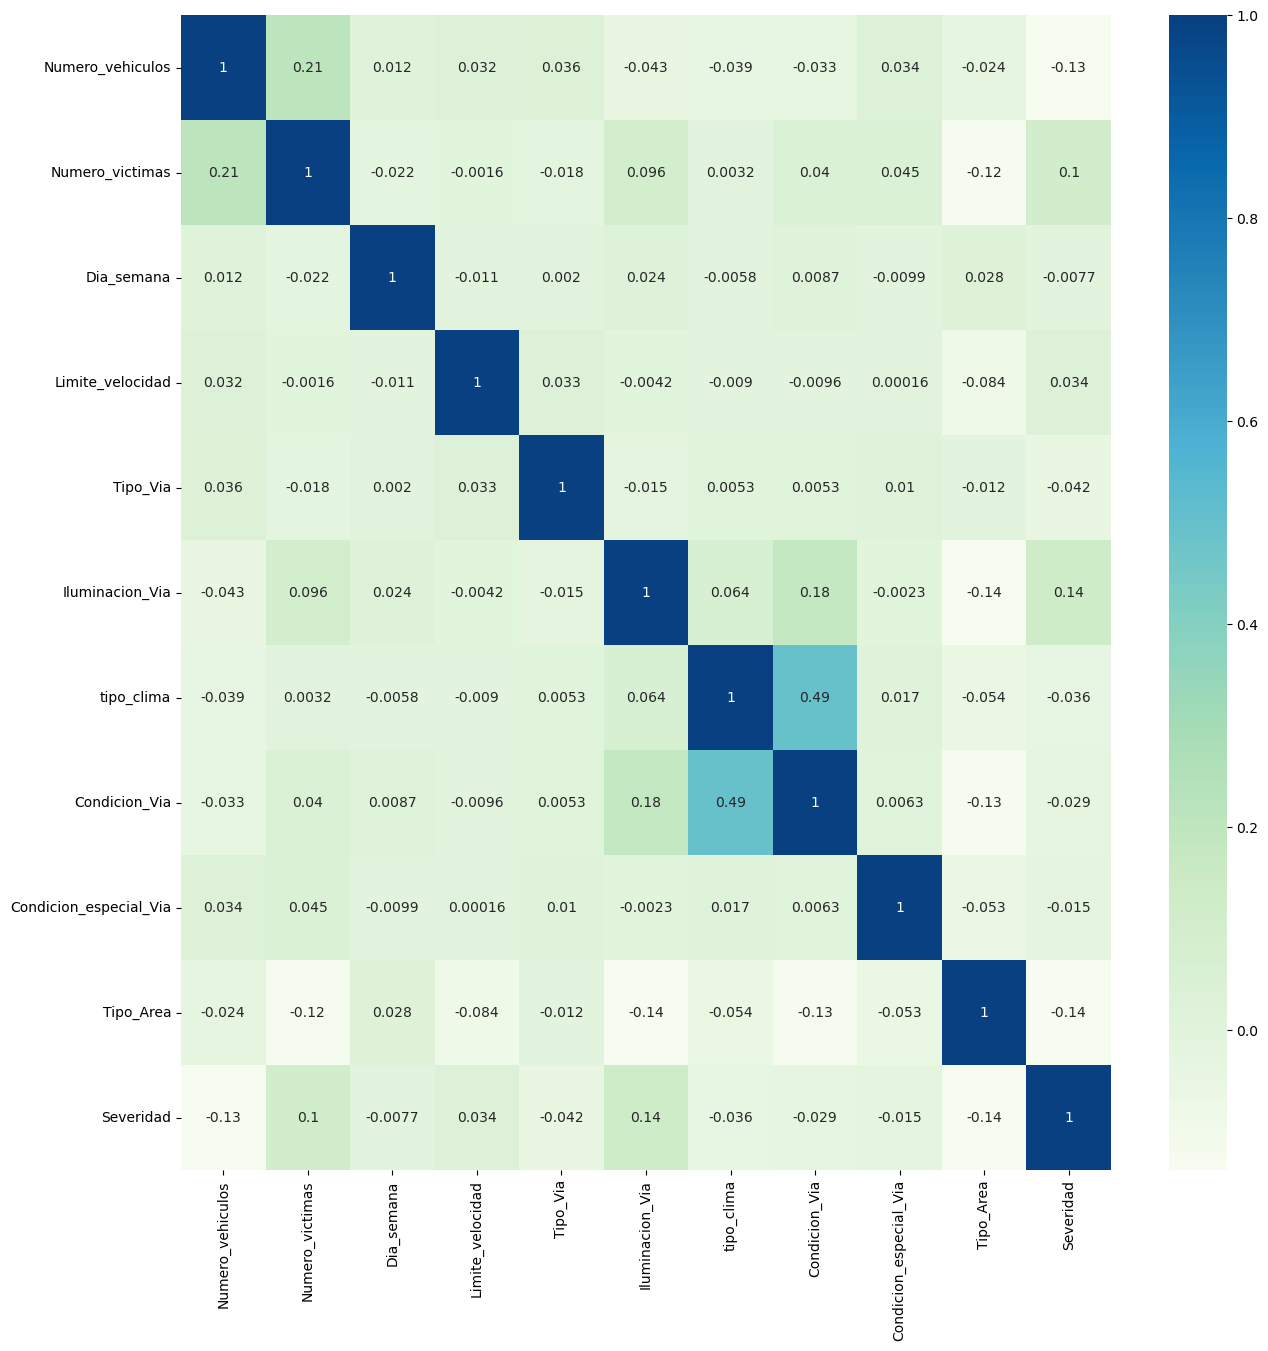

In [30]:
# ¿Hay correlación entre variables?
plt.figure(figsize =(15,15))
correlacion = df_model.corr()
sns.heatmap(correlacion, cmap = 'GnBu', annot = True)
plt.show()

### 4. Construcción del modelo


In [31]:
# Se selecciona la variable objetivo, en este caso "Severidad".
Y = df_model['Severidad']
# Del conjunto de datos se elimina la variable "Severidad"
X = df_model.drop(['Severidad'], axis=1)

In [32]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [33]:
# Primero se crea el objeto para construir el modelo
modelo_regresion = LinearRegression()

In [34]:
# Ajustar el modelo con los datos de entrenamiento
modelo_regresion.fit(X_train,Y_train)

LinearRegression()

### 5. Evaluación del modelo
Las métricas de evaluación nos van a permitir determinar qué tan bien se desempeña un modelo; es decir, cómo se ajusta a los datos. En esta sección se utilizan las siguientes métricas

1. Mean-Squared-Error(MSE). Error medio cuadrático
2. Mean-Absolute-Error(MAE). Error absoluto medio
3. R² or Coeficiente de determinación.

In [35]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred = modelo_regresion.predict(X_train)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("MSE: %.2f" % mean_squared_error(Y_train, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(Y_train, y_pred))
print('R²: %.2f' % r2_score(Y_train, y_pred))

MSE: 0.65
MAE: 0.54
R²: 0.07


In [36]:
# Se obtienen las predicciones del modelo sobre el conjunto test.
y_pred = modelo_regresion.predict(X_test)
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
print("MSE: %.2f" % mean_squared_error(Y_test, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(Y_test, y_pred))
print('R²: %.2f' % r2_score(Y_test, y_pred))

MSE: 0.63
MAE: 0.53
R²: 0.07


Podemos ver que tenemos un R2 muy bajo, esto se debe a seleccionar una gran cantidad de variables y no centrarlas en las más importantes.
De la misma forma, el error medio cuadrático nos indica que en promedio, los valores se encuentran alejados 0.63 puntos de la _Severidad_ que deberían ser clasificados, aunque es un valor bajo, esto es malo debido a que la separación entre la clasificación de Severidad es de 1 punto.

In [37]:
# Ajustar el modelo con los datos de entrenamiento
modelo_regresion.fit(X,Y)

LinearRegression()

In [38]:
# Podemos visualizar los parámetros del modelos (coeficientes de regresión)
modelo_regresion.coef_

array([-1.48507702e-01,  9.09097187e-02, -6.85927971e-04,  9.66833178e-05,
       -3.05618582e-02,  1.17949182e-01, -2.11935227e-02, -7.33393106e-02,
       -9.09510195e-02, -1.69321007e-01])

In [39]:
# importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia = modelo_regresion.coef_
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,Iluminacion_Via,0.117949
1,Numero_victimas,0.090910
2,Limite_velocidad,0.000097
3,Dia_semana,-0.000686
4,tipo_clima,-0.021194
5,Tipo_Via,-0.030562
6,Condicion_Via,-0.073339
7,Condicion_especial_Via,-0.090951
8,Numero_vehiculos,-0.148508
9,Tipo_Area,-0.169321


Como podemos ver, el atributo con más importancia es la iluminación de la vía, el tipo de área y el número de vehículos. Esto pudo ser identificado al ser las variables con mayor relación en la matriz de correlación.

No se debe tener en cuenta la variable de número de victimas debido a que la cantidad de victimas no es un número que se puede conocer con anterioridad para predecir la gravedad de un incidente.

### 6. Interpretación del modelo

Podemos sacar un reporte que nos va a permitir analizar estadísticos del modelo.

In [40]:
# Ajustar el modelo para ver el reporte
model = sm.OLS(Y, X).fit() ## sm.OLS(output, input)
# Mostrar las estadísticas del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Severidad   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.791
Method:                 Least Squares   F-statistic:                              1050.
Date:                Thu, 30 Sep 2021   Prob (F-statistic):                        0.00
Time:                        09:14:51   Log-Likelihood:                         -3022.0
No. Observations:                2768   AIC:                                      6064.
Df Residuals:                    2758   BIC:                                      6123.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Numero_vehiculos           0.0402      0.018      2.264      0.024       0.005       0.075
Numero_victimas            0.1724      0.016     10.477      0.000       0.140       0.205
Dia_semana                 0.0568      0.006      8.756      0.000       0.044       0.070
Limite_velocidad           0.0002   6.61e-05      2.793      0.005     5.5e-05       0.000
Tipo_Via                   0.1011      0.017      5.949      0.000       0.068       0.134
Iluminacion_Via            0.2926      0.020     14.378      0.000       0.253       0.332
tipo_clima                 0.0315      0.019      1.627      0.104      -0.006       0.070
Condicion_Via              0.1261      0.027      4.641      0.000       0.073       0.179
Condicion_especial_Via    -0.0470      0.096     -0.489      0.625      -0.235       0.141
Tipo_Area                  0.0989      0.028      3.582      0.000       0.045       0.153
==============================================================================
Omnibus:                      290.236   Durbin-Watson:                   0.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              386.178
Skew:                           0.903   Prob(JB):                     1.39e-84
Kurtosis:                       3.294   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Los resultados con respecto a la primera técnica de modelado (árbol de clasificación) son mediocres. 

Esto se debe por varias razones: hay una poca cantidad de datos, varias de las variables utilizadas son categóricas, la variable objetivo es categórica y hace falta una mejor preparación de los datos específicamente para el modelo de regresión.

Esta técnica es buena para intentar predecir el outcome de la variable, que para el negocio sería de gran importancia, pues se podría predecir basado en una ecuación la gravedad de un accidente de tráfico antes que suceda, basado en variables como el tipo de área (rural, urbano), la iluminación de la vía, condiciones especiales de la vía, etc. con el fin de hacer mayores medidas preventivas según sea el caso.

Sin embargo, para los datos obtenidos sobre los incidentes de tráfico, se debe preferir una técnica de clásificación sobre una regresión lineal.